In [85]:
import json
import os
import glob
import requests
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point

In [59]:
MAIRIES_FILE = 'data/mairies-martinique.geojson'
COMMUNES_FILES = 'data/communes-martinique.geojson'

gdf_mq = gpd.read_file(COMMUNES_FILES)
gdf_mq['code'] = gdf_mq['code'].astype(int)
gdf_mq_mairie = gpd.read_file(MAIRIES_FILE)
gdf_mq_mairie['code'] = gdf_mq_mairie['codgeo'].astype(int)
gdf_mq_mairie.head(1)

,codgeo,geometry,code
0,97201,POINT (-61.11450 14.82480),97201


In [17]:
!curl https://raw.githubusercontent.com/glefait/martinique-public-websites/master/.upptimerc.yml > data-tmp/.upptimerc.yml
!cat data-tmp/.upptimerc.yml | fgrep url|sed -r 's#.*url: https?://##' > data-tmp/domains
!mkdir -p data-tmp/digs/
!cat data-tmp/domains | while read domain; do dig $domain +short | grep '^[.0-9]*$' > data-tmp/digs/$domain; done

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4455  100  4455    0     0  12227      0 --:--:-- --:--:-- --:--:-- 12239


In [24]:
# url to ip to geoloc
domains_geoloc = []
for f in glob.glob("data-tmp/digs/*"):
    domain = f.split('/')[-1]
    with open(f) as r:
        for line in r:
            ip = line.strip()
            res = requests.get(f'http://ip-api.com/json/{ip}').json()
            if res['status'] != 'success':
                continue
            domains_geoloc.append([domain, res['country'], res['lon'], res['lat'], res['org']])

In [46]:
domains_geoloc_df = pd.DataFrame(domains_geoloc, columns=['domain', 'country', 'lon', 'lat', 'org'])
domains_geoloc_df.head(1)

,domain,country,lon,lat,org
0,collecte-dechets.cacem.fr,Canada,-73.8779,45.3151,"OVH Hosting, Inc."


In [47]:
# get Uptime
uptime = requests.get("https://raw.githubusercontent.com/glefait/martinique-public-websites/master/history/summary.json").json()
# use a fast lookup dict 
uptimes = {
    x['url'][x['url'].find('://')+3:]: x
    for x in uptime
}

uptime_data = [
    [k, float(uptimes[k]['uptimeYear'][:-1])] for k in uptimes
]
uptime_df = pd.DataFrame(uptime_data, columns=['domain', 'uptime_year'])
uptime_df.head(1)

,domain,uptime_year
0,www.collectivitedemartinique.mq,97.13


In [50]:
# get service addresse
# some are from api_adresse

def api_lat_lon_score(address):
    r = requests.get("https://api-adresse.data.gouv.fr/search/", params={"q": address, "limit": 1})
    lon, lat, score = None, None, None
    if r.status_code == 200:   
        response = r.json()
        if 'features' in response and len(response['features']) > 0:
            feature = response['features'][0]
            if "geometry" in feature and "coordinates" in feature['geometry']:
                lon, lat = feature['geometry']['coordinates']
            if "properties" in feature and "score" in feature['properties']:
                score = response['features'][0]['properties']['score']
    else:
        print(r.status_code, r.text)
    return pd.Series([lon, lat, score])

    # this takes time (30 - 45 minutes) but we play nice with API server

domains_addresses = [
    ['www.collectivitedemartinique.mq', 'Rue Gaston-Defferre, 97201 Fort-de-France Cedex, Martinique'],
    ['www.cacem.fr', 'Place Francois Mitterrand 97200 Fort-de-France'],
    ['espacesud.fr', 'Lotissement Les Frangipaniers, 97228 Sainte-Luce '],
    ['www.capnordmartinique.fr', 'Lotissement la Marie 97225 Le Marigot'],
    ['www.martinique.org', 'Pointe de Jaham 97233 Schœlcher'],
    ['www.martiniquetransport.mq', 'zac étang z abricot 97200 Fort-de-France'],
    ['www.observatoire-eau-martinique.fr', '4 Avenue Condorcet 97200 Fort-de-France'],
    ['www.odyssi.fr', '9 Rue des Arts et Metiers 97200 Fort-de-France'],
    ['www.cesecem.mq', 'Rue Gaston-Defferre, 97201 Fort-de-France Cedex, Martinique'],
    ['pnr-martinique.com', '5 avenue Saint John Perse 97200 FORT DE FRANCE'],
    ['mdph972.fr', '1 Rue Georges Eucharis 97200 Fort-de-France'],
    ['www.agefma.mq', 'Rue du Gouverneur Ponton 97200 - FORT DE FRANCE'],
    ['tropiques-atrium.fr', '6 Rue Jacques Cazotte, Fort-de-France 97200, Martinique'],
    ['www.martiniquedev.fr', 'rue du gouverneur ponton, place lafcadio Hearn, immeuble 2000 97200 Fort-de-France'],
    ['cca-martinique.com', 'Rue des Artistes 97200 Fort-de-France'],
    ['www.technopolemartinique.org', 'zac étang z abricot 97200 Fort-de-France'],
    ['parm.mq', 'Impasse Petit Morne 97232 Le Lamentin'],
    ['www.biodiversite-martinique.fr', 'Morne Tartenson Ouest 97200 Fort-de-France'],
    ['www.initiative-martinique.com', 'rue du gouverneur ponton, place lafcadio Hearn, immeuble 2000 97200 Fort-de-France'],
    ['www.ims.mq', 'Chemin Mangot Vulcin 97232 Le Lamentin, Martinique'],
    ['www.adilmartinique.org', '13 Rue du Commerce 97200 Fort-de-France'],
    ['imfpa.mq', '6 Avenue des Arawaks 97200 Fort-de-France'],
    ['hippodromedecarrere.fr', 'Habitation Carrere 97232 Le Lamentin'],
    ['saem-legalion.net', 'Usine du Galion 97220 La Trinité'],
    ['grandebaiemartinique.com', 'Place Francois Mitterrand 97200 Fort-de-France'],
    ['collecte-dechets.cacem.fr', 'Place Francois Mitterrand 97200 Fort-de-France'],
    ['www.milcem.com', '54 Chemin des Chataigniers 97232 Le Lamentin'],
    ['tourisme-centre.fr', 'Rue Bord de Mer 97233 Schœlcher'],
    ['www.martinique.gouv.fr', 'Rue Louis Blanc 97200 Fort-de-France'],
    ['www.smtvd.fr', 'Pointe Jean Claude 97231 Le Robert'],
    ['www.zetwal.mq', 'rue du gouverneur ponton, place lafcadio Hearn, immeuble 2000 97200 Fort-de-France'],
]

domains_addresses_df = pd.DataFrame(domains_addresses, columns=['domain', 'adresse'])
domains_addresses_df[['lon', 'lat', 'score']] = domains_addresses_df.apply(lambda x: api_lat_lon_score(x['adresse']), axis=1)
domains_addresses_df.head(1)

,domain,adresse,lon,lat,score
0,www.collectivitedemartinique.mq,"Rue Gaston-Defferre, 97201 Fort-de-France Cede...",-61.07948,14.617858,0.583045


In [71]:
# now get the mairies
domain_to_insee_code = {
    'mairiecasepilote.fr': 97205,
    'riviere-salee.fr': 97221,
    'rivierepilote.fr': 97220,
    'saintjoseph972.com': 97224,
    'saintpierre-mq.fr': 97225,
    'ville-ansesdarlet.fr': 97202,
    'ville-vauclin.fr': 97232,
    'villedestroisilets.com': 97231,
    'villedulorrain.com': 97214,
    'www.fortdefrance.fr': 97209,
    'www.mairie-latrinite.fr': 97230,
    'www.mairie-lelamentin.fr': 97213,
    'www.mairie-schoelcher.fr': 97229,
    'www.morne-vert.fr': 97233,
    'www.sainteluce.fr': 97227,
    'www.ville-francois.fr': 97210,
    'www.ville-robert.fr': 97222,
    'www.ville-saintemarie.fr': 97228,
    'www.villeducarbet.fr': 97204,
}
domain_to_insee_code_data = [[k, domain_to_insee_code[k]] for k in domain_to_insee_code]
domain_to_insee_code_df = pd.DataFrame(domain_to_insee_code_data, columns=['domain', 'code']).merge(gdf_mq_mairie, how='inner')
domain_to_insee_code_df['lon'] = domain_to_insee_code_df.geometry.apply(lambda p: p.x)
domain_to_insee_code_df['lat'] = domain_to_insee_code_df.geometry.apply(lambda p: p.y)

In [79]:
# aggregate location from mairie / addresse
domains_entity_geoloc = pd.concat([domains_addresses_df, domain_to_insee_code_df]).reset_index(drop=True)[['domain', 'lon', 'lat']].rename(columns={'lon': 'entity_lon', 'lat': 'entity_lat'})
domains_entity_geoloc.head(1)

,domain,entity_lon,entity_lat
0,www.collectivitedemartinique.mq,-61.07948,14.617858


/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


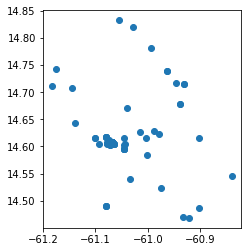

In [97]:
all_data = domains_geoloc_df.merge(domains_entity_geoloc, on='domain').merge(uptime_df, on='domain')
all_data['geometry'] = all_data.apply(lambda x: Point(x['entity_lon'], x['entity_lat']), axis=1)
all_data['geometry_hosting'] = all_data.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
all_data['link'] = all_data.apply(lambda row: LineString([row['geometry'], row['geometry_hosting']]), axis=1)
all_data = gpd.GeoDataFrame(all_data).set_crs('EPSG:4326')
_ = all_data.plot()

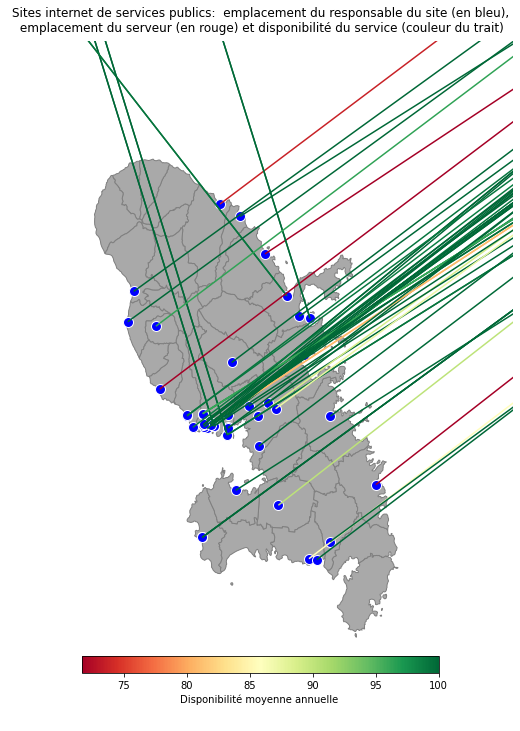

In [205]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle('Sites internet de services publics:  emplacement du responsable du site (en bleu),\n emplacement du serveur (en rouge) et disponibilité du service (couleur du trait)')
gdf_mq.plot(ax=ax, color="darkgray", edgecolor='gray')
all_data.set_geometry('link').plot(ax=ax, column="uptime_year", cmap="RdYlGn", legend=True, 
                                   legend_kwds={"pad": -0.1, "location":"bottom", "label": "Disponibilité moyenne annuelle ", "shrink":0.5})

all_data.plot(ax=ax, color="blue", edgecolor='white', markersize=100)
all_data.set_geometry('geometry_hosting').plot(ax=ax, color="red", markersize=100)

ax.set_xlim(-61.35, -60.65)
ax.set_ylim(14.3, 15)

_ = ax.axis('off')

fig.savefig('output/2022-11-20a.png', facecolor='white')

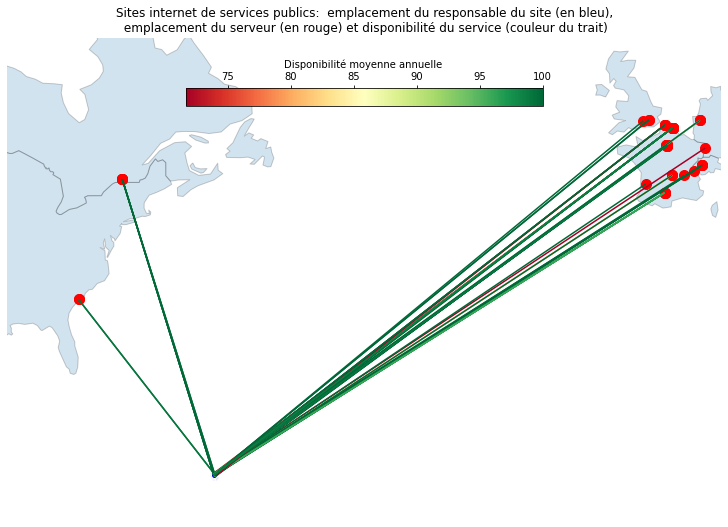

In [206]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle('Sites internet de services publics:  emplacement du responsable du site (en bleu),\n emplacement du serveur (en rouge) et disponibilité du service (couleur du trait)')
gdf_mq.plot(ax=ax, color="darkgray", edgecolor='gray')
all_data.set_geometry('link').plot(ax=ax, column="uptime_year", cmap="RdYlGn", legend=True, 
                                   legend_kwds={"pad": -0.1, "location":"top", "label": "Disponibilité moyenne annuelle ", "shrink":0.5})

world.loc[(world.name.isin(['France', 'Canada', 'United States of America', 'United Kingdom', 'Germany', 'Switzerland']))].to_crs('EPSG:4326').plot(alpha = 0.2, edgecolor = "k", ax = ax)
all_data.plot(ax=ax, color="blue", edgecolor='white')
all_data.set_geometry('geometry_hosting').plot(ax=ax, color="red", markersize=100)

ax.set_xlim(-90, 10)
ax.set_ylim(10, 60)

_ = ax.axis('off')

fig.savefig('output/2022-11-20b.png', facecolor='white')